# SuperStore EDA and Forecasting

In this notebook, I am interested in looking into a store's sales data. Speicifically, I want to focus on learning about the "Furniture" category of the sales, look into other features, and perform a time-series forecasting on the sales data.

In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from datetime import timedelta

import plotly.graph_objects as go
from plotly.offline import iplot, plot

import prophet
from prophet.plot import add_changepoints_to_plot

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688  12/06/2017  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product ID         Category Sub-Category  \
0      42420.0  South  FUR-BO-10001798        Furniture    Bookcases   
1      42420.0  South  FUR-CH-10000454        Furniture       Chairs   
2      90036.0   West  OFF-LA-10000240  Office Supplies       Labels   
3      33311.0  South  FUR-TA-10000577        Furniture       Tables   
4      33311.0  South  OFF-ST-10000760  Office Supplies      Storage   

                                        Product Name     Sales  
0                  Bush Somerset Collection Bookcase  261.9600  
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.9400  
2  Self-Adhesive Address Labels for Typewriters b...   14.6200  
3      Bretford CR4500 Series Slim Rectangular Table  957.5775  
4                     Eldon Fold 'N Roll Cart System   22.3680

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [6]:
df.nunique()

Row ID           9800
Order ID         4922
Order Date       1230
Ship Date        1326
Ship Mode           4
Customer ID       793
Customer Name     793
Segment             3
Country             1
City              529
State              49
Postal Code       626
Region              4
Product ID       1861
Category            3
Sub-Category       17
Product Name     1849
Sales            5757
dtype: int64

There are too many Row ID, Order ID, Customer ID, Customer Name, City, Postal Code, Product ID, and Product Name to potentially sort by, so I will remove all these.

In [7]:
cols_to_remove = ['Row ID', 'Order ID', 'Customer ID', 'Customer Name', 'City', 
                  'Postal Code', 'Product ID', 'Product Name', 'Ship Date']

df.drop(cols_to_remove, axis=1, inplace=True)

In [8]:
df.isnull().sum()

Order Date      0
Ship Mode       0
Segment         0
Country         0
State           0
Region          0
Category        0
Sub-Category    0
Sales           0
dtype: int64

### Date Parameters
I now will add date parameters to make it easier to look at the data.

In [9]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')

In [10]:
def get_week_start(dates):
    """
    For any given date data, convert all dates
    to the date for the start of the week (Monday).
    dates should given as a pd.series datetime.
    """
    dates_list = dates.tolist()
    deltas = dates.dt.dayofweek.tolist()
    
    new_dates = []
    
    for i in range(len(dates_list)):
        new_date = dates_list[i]-timedelta(int(deltas[i]))
        new_dates.append(new_date)
        
    return pd.Series(new_dates)

In [11]:
print(get_week_start(df['Order Date']))

0      2017-11-06
1      2017-11-06
2      2017-06-12
3      2016-10-10
4      2016-10-10
          ...    
9795   2017-05-15
9796   2016-01-11
9797   2016-01-11
9798   2016-01-11
9799   2016-01-11
Length: 9800, dtype: datetime64[ns]


In [12]:

# Create cols for month, day, year
df['Order Year'] = df['Order Date'].apply(lambda x: x.year)
df['Order Month/Year'] = df['Order Date'].apply(lambda x: datetime.datetime(x.year, x.month, 1))
df['Order Month'] = df['Order Date'].apply(lambda x: x.month)
df['Order Week'] = get_week_start(df['Order Date'])
df['Order Day of Week'] = df['Order Date'].apply(lambda x: x.strftime('%a'))

# Sort data by order date for for ease of use
df.sort_values(by='Order Date', ascending=True, inplace=True)

In [13]:
df.head()

Order Date       Ship Mode      Segment        Country         State  \
7980 2015-01-03  Standard Class     Consumer  United States         Texas   
741  2015-01-04  Standard Class  Home Office  United States      Illinois   
740  2015-01-04  Standard Class  Home Office  United States      Illinois   
739  2015-01-04  Standard Class  Home Office  United States      Illinois   
1759 2015-01-05  Standard Class     Consumer  United States  Pennsylvania   

       Region         Category Sub-Category    Sales  Order Year  \
7980  Central  Office Supplies        Paper   16.448        2015   
741   Central  Office Supplies      Binders    3.540        2015   
740   Central  Office Supplies      Storage  272.736        2015   
739   Central  Office Supplies       Labels   11.784        2015   
1759     East  Office Supplies          Art   19.536        2015   

     Order Month/Year  Order Month Order Week Order Day of Week  
7980       2015-01-01            1 2014-12-29               Sat  
741        2015-01-01            1 2014-12-29               Sun  
740        2015-01-01            1 2014-12-29               Sun  
739        2015-01-01            1 2014-12-29               Sun  
1759       2015-01-01            1 2015-01-05               Mon

In [14]:
df['Order Week'].isnull().sum()

0

### Categories

I first to look into each category as there are not many to see if there are clear differences between them.

In [15]:
df['Category'].unique()

array(['Office Supplies', 'Technology', 'Furniture'], dtype=object)

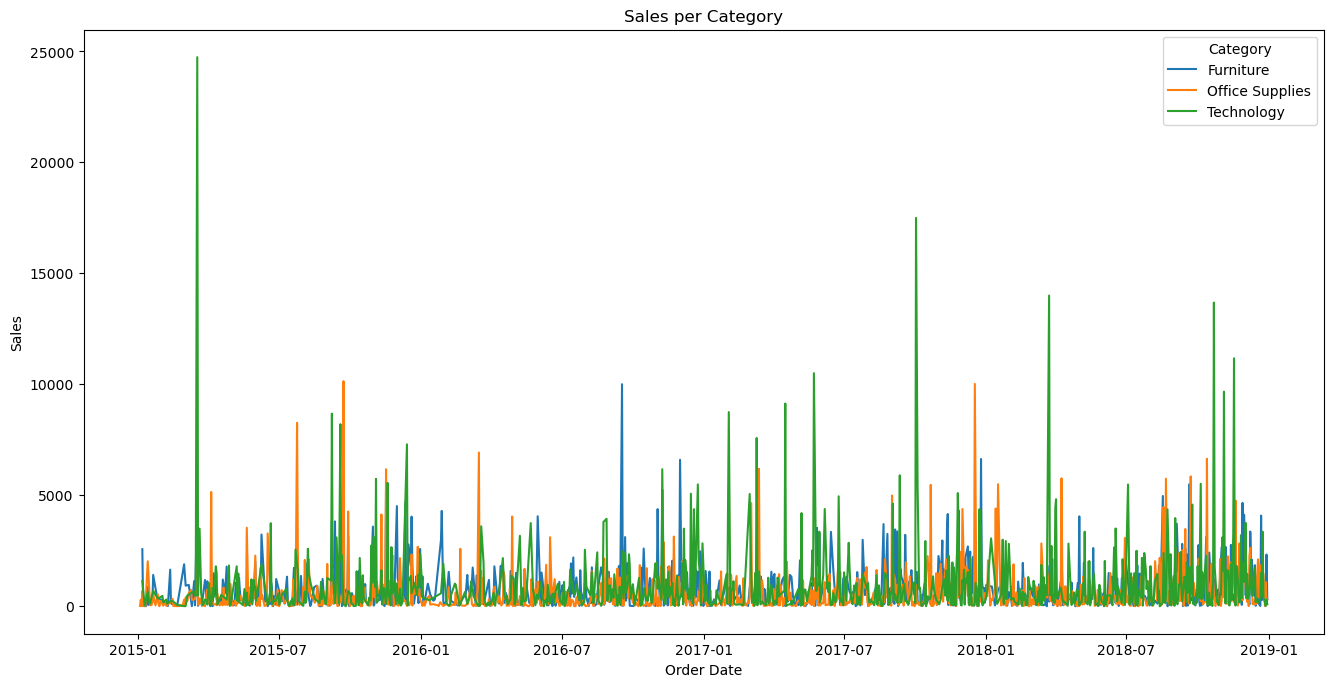

In [16]:
cats = df.groupby(['Category', 'Order Date']).sum()['Sales'].reset_index()

plt.figure(figsize=(16, 8), dpi=100)
sns.lineplot(data=cats, x='Order Date', y='Sales', hue='Category')
plt.title('Sales per Category');

Not much can be seen here, but Technology seems to have much higher spikes than Furniture or Office Supplies. I will look at each category on a more broad time-scale.

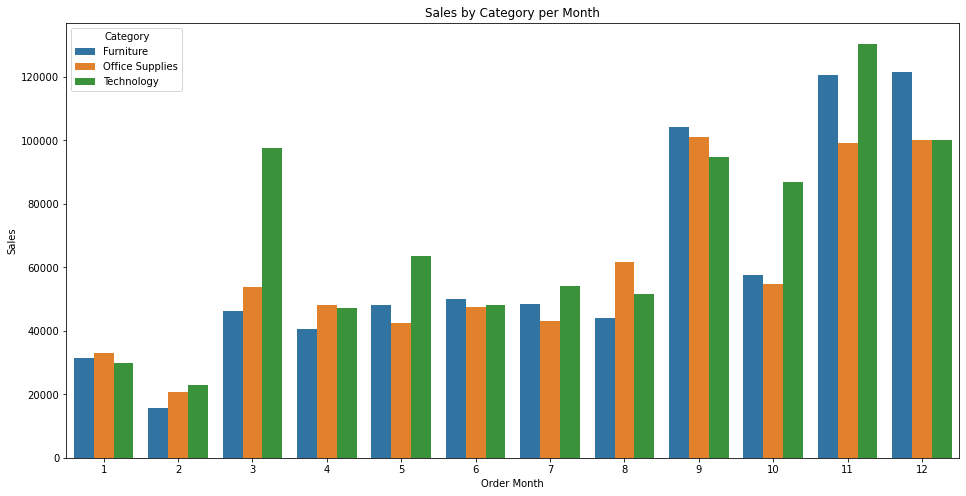

In [17]:
month_cats = df.groupby(['Category', 'Order Month']).sum()['Sales'].reset_index()

plt.figure(figsize=(16, 8))
sns.barplot(data=month_cats, x='Order Month', y='Sales', hue='Category')
plt.title('Sales by Category per Month');

At the scale of a month, there is not much difference between the three catgories as far as sales (except in March).

Text(0.5, 1.0, 'Sales by Category per Year')

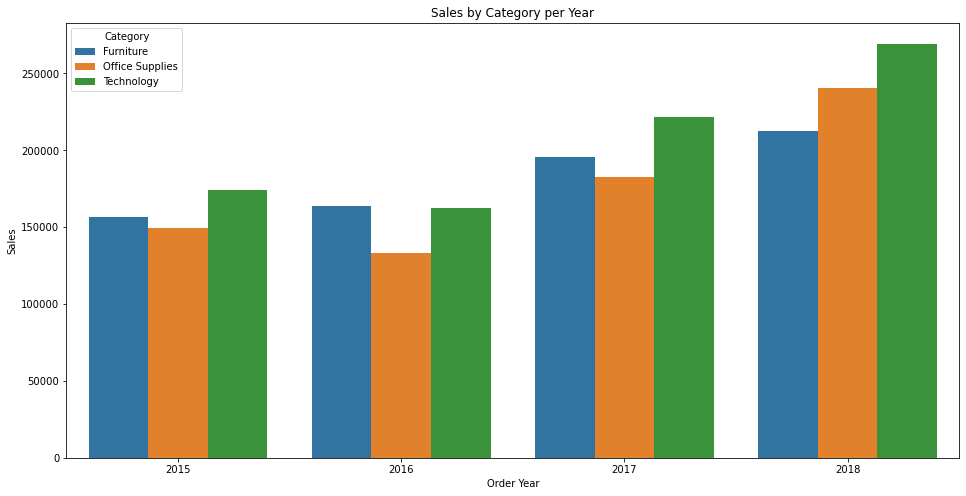

In [18]:
year_cats = df.groupby(['Category', 'Order Year']).sum()['Sales'].reset_index()

plt.figure(figsize=(16, 8))
sns.barplot(data=year_cats, x='Order Year', y='Sales', hue='Category')
plt.title('Sales by Category per Year')

As we can see

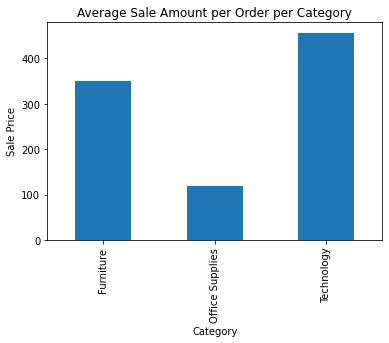

In [19]:
sales_category = df.groupby(['Category']).mean()['Sales'].plot(kind='bar')
plt.title('Average Sale Amount per Order per Category')
plt.ylabel('Sale Price');

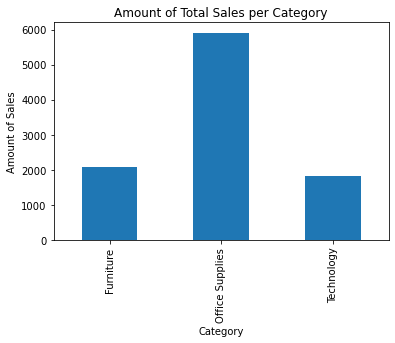

In [20]:
sales_category = df.groupby(['Category']).count()['Sales'].plot(kind='bar')
plt.title('Amount of Total Sales per Category')
plt.ylabel('Amount of Sales');

As we can see, the average sale amount differs drastically between the three categories. Because of this, when forecasting, it is a good idea to forecast each individual category's sales.

For the sake of repetition in this notebook, I will only forecast the Furniture.

### Furniture

I will now turn the focus to only the furniture category.

To make it easier, I will relabel df as the dataframe with just furniture category sales.

In [21]:
df = df[df['Category']=='Furniture']

In [22]:
df.nunique()

Order Date            877
Ship Mode               4
Segment                 3
Country                 1
State                  48
Region                  4
Category                1
Sub-Category            4
Sales                1611
Order Year              4
Order Month/Year       48
Order Month            12
Order Week            208
Order Day of Week       7
dtype: int64

In the furniture category, we can see there are only four sub-categories: It might be useful to explore each one

### Sales

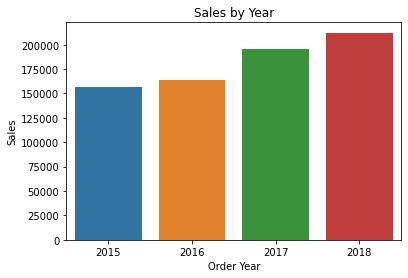

In [23]:
sales_year = df.groupby('Order Year').sum()['Sales'].reset_index()
sns.barplot(data=sales_year, x='Order Year', y='Sales')
plt.title('Sales by Year');

As we can see, the sales per year are increasing overall.

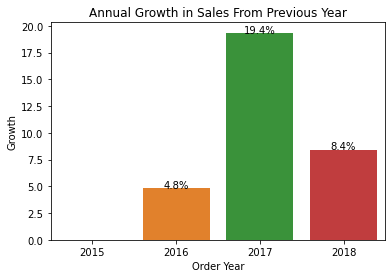

In [24]:
curr = sales_year['Sales']
prev = sales_year['Sales'].shift(periods=1)
sales_year['Growth'] = (curr-prev)/prev*100


sns.barplot(data=sales_year, x='Order Year', y='Growth')
for i in range(sales_year.shape[0]):
    plt.annotate(text=f"{np.round(sales_year['Growth'][i], 1)}%", 
                 xy=(i, sales_year['Growth'][i]), 
                 horizontalalignment='center')
plt.title('Annual Growth in Sales From Previous Year');

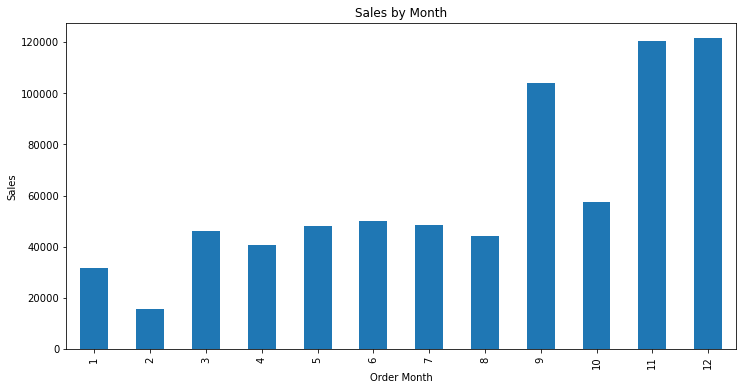

In [25]:
df.groupby('Order Month').sum()['Sales'].plot(kind='bar', figsize=(12, 6), ylabel='Sales')
plt.title('Sales by Month');

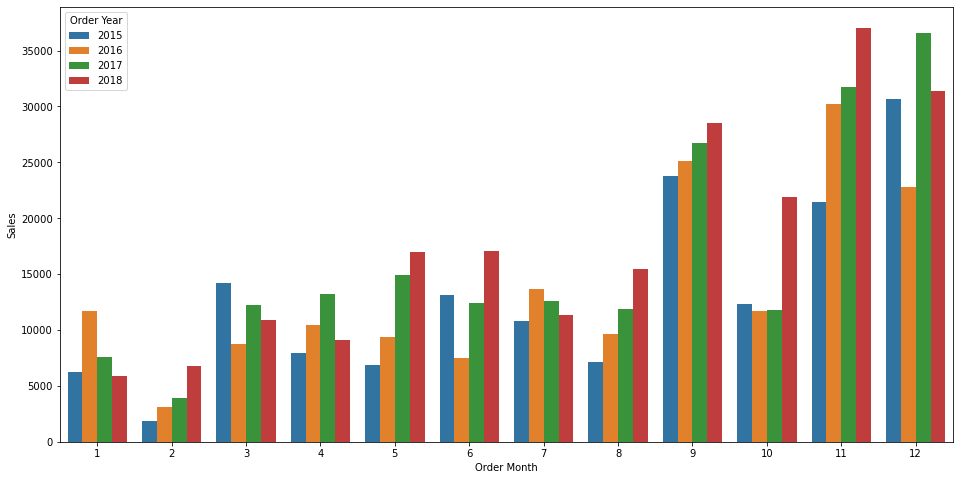

In [26]:
sales_month_year = df.groupby(['Order Year', 'Order Month']).sum()['Sales'].reset_index()

plt.figure(figsize=(16, 8))
sns.barplot(data=sales_month_year, x='Order Month', y='Sales', hue='Order Year');

As we can see, the sales per month are highest in September, November, and December, Lowest in January and February, and in between during the rest.

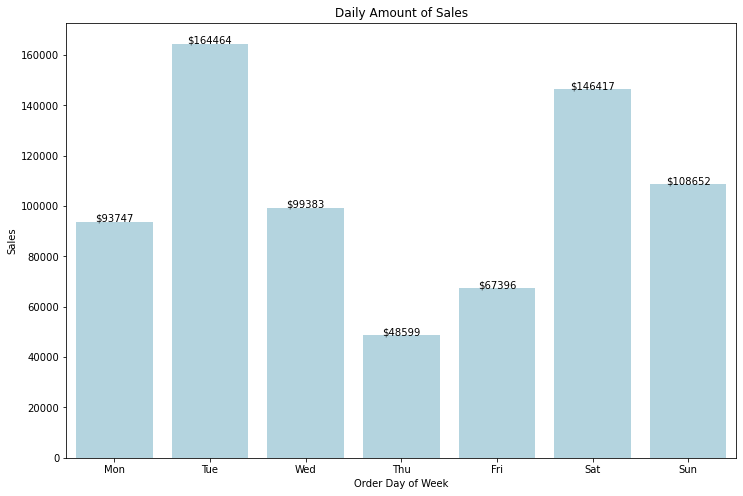

In [27]:
df['Order Day of Week'] = pd.Categorical(df['Order Day of Week'], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
daily_sales = df.groupby('Order Day of Week').sum()['Sales'].reset_index().sort_values(by='Order Day of Week')

plt.figure(figsize=(12, 8))
sns.barplot(data=daily_sales, x='Order Day of Week', y='Sales', color='lightblue')
plt.title('Daily Amount of Sales')

sales = daily_sales['Sales']
for i in range(len(sales)):
    plt.annotate(f"${np.round(sales[i]).astype(int)}", (i, sales[i]), horizontalalignment='center');

<AxesSubplot:xlabel='Order Month', ylabel='Sales'>

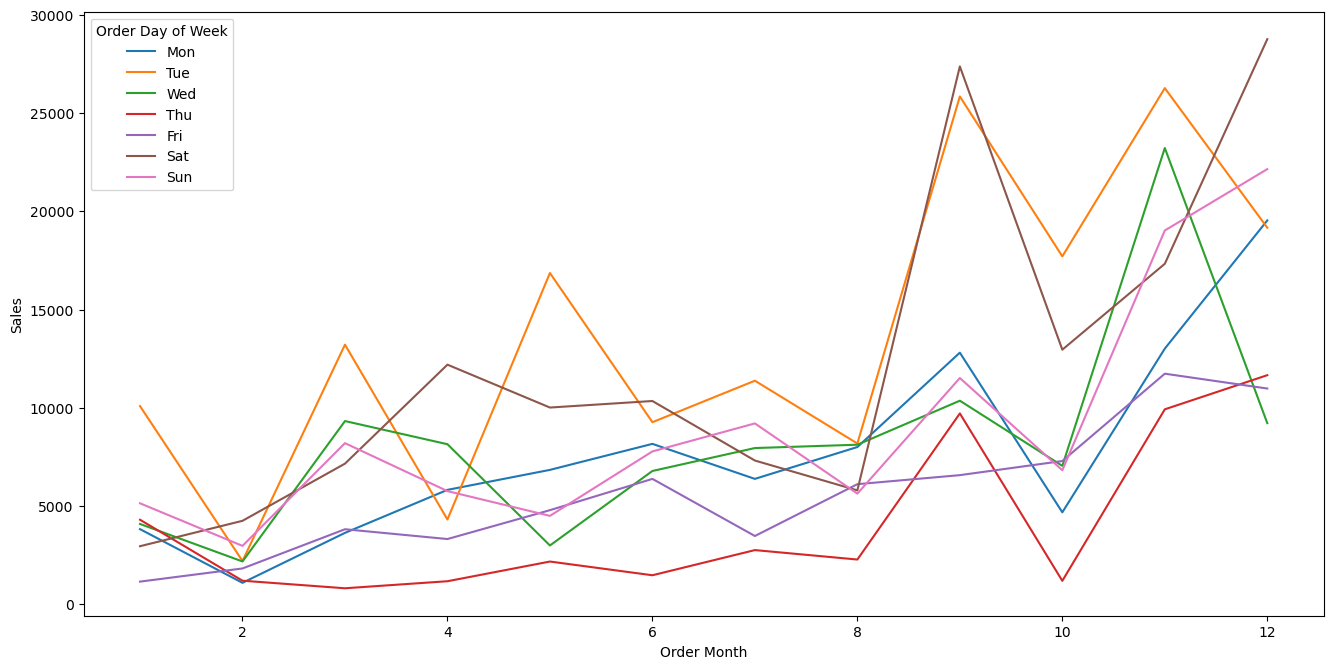

In [28]:
daily_month_sales = df.groupby(['Order Month', 'Order Day of Week']).sum()['Sales'].reset_index()

plt.figure(figsize=(16,8), dpi=100)
sns.lineplot(data=daily_month_sales, x='Order Month', y='Sales', hue='Order Day of Week')

<AxesSubplot:xlabel='Order Date', ylabel='Sales'>

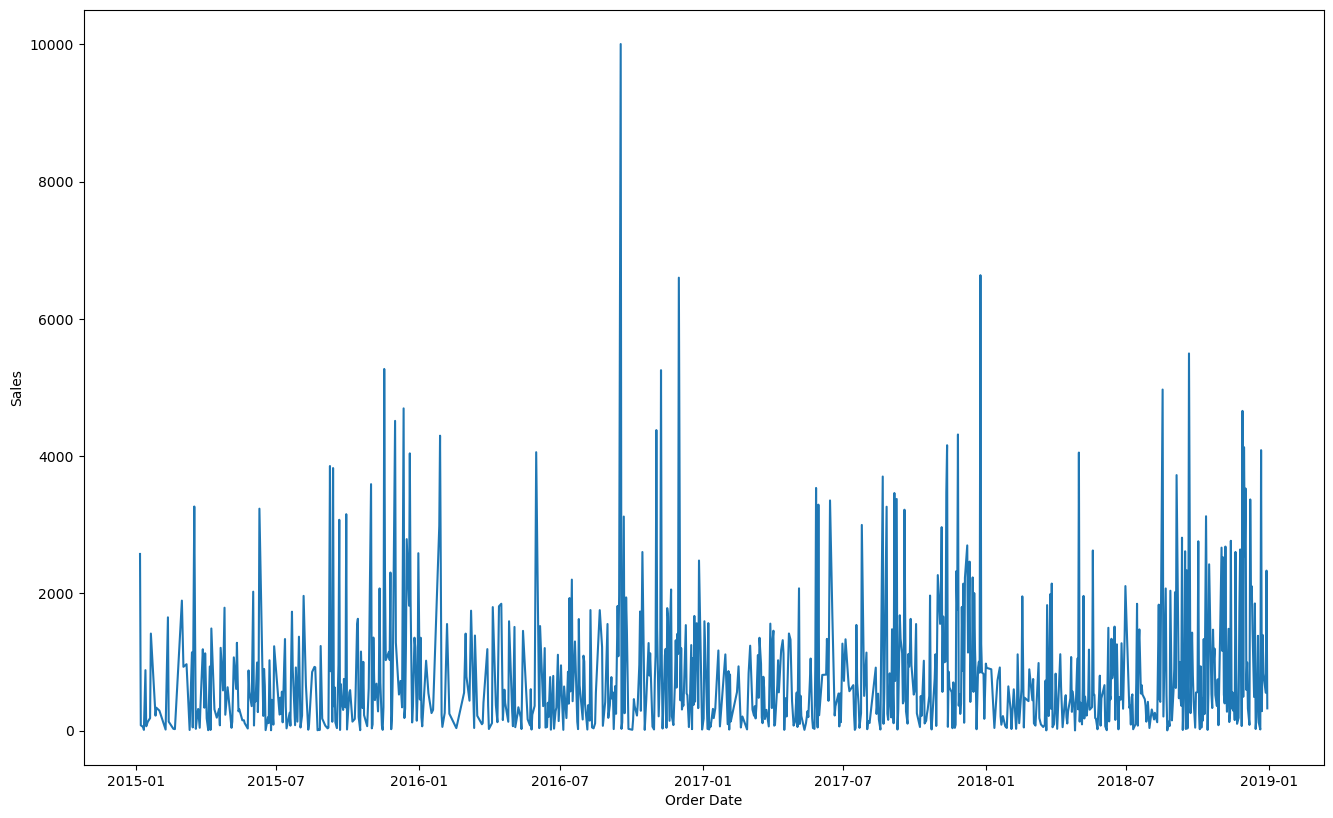

In [29]:
daily_sales = df.groupby(['Order Date']).sum()['Sales'].reset_index()

plt.figure(figsize=(16,10), dpi=100)
sns.lineplot(data=daily_sales, x='Order Date', y='Sales')

The daily sales for the entire dataset above shows some very sharp peaks/valleys. While Fourier series approximations are good at estimating periodic behavior, it is probably best to look into other features to see if forecasting individual features would be wiser.

### Sub-Category

In [30]:
df['Sub-Category'].unique()

array(['Chairs', 'Furnishings', 'Bookcases', 'Tables'], dtype=object)

Look into the average sale per purhcase for each sub-category as they could have vastly different numbers

<AxesSubplot:xlabel='Sub-Category'>

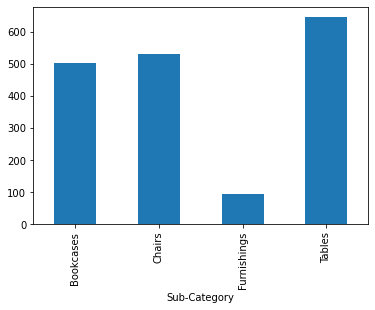

In [31]:
df.groupby('Sub-Category')['Sales'].mean().plot(kind='bar')

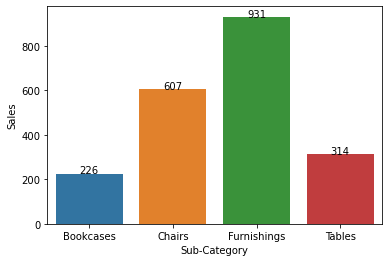

In [32]:
counts = df.groupby('Sub-Category')['Sales'].count().reset_index()

plot = sns.barplot(data=counts, x=counts['Sub-Category'], y=counts['Sales'])

for i in range(len(counts)):
    plot.annotate(counts['Sales'][i], (i, counts['Sales'][i]), horizontalalignment='center')

In [33]:
df['Order Date'].nunique()

877

As we can see, the number of bookcases and tables sold is very low compared to the number of order dates. Since Chairs are similarly prices (as far as average sale) as bookcases, and tables is only a little bit higher, it may make sense to reconstruct the sub-categories to "Furnishings" and "Non-Furnishings"

In [34]:
df['Sub-Category'] = df['Sub-Category'].replace({'Bookcases': 'Non-Furnishings', 
                                                 'Chairs': 'Non-Furnishings', 
                                                 'Tables': 'Non-Furnishings'})

<AxesSubplot:xlabel='Sub-Category'>

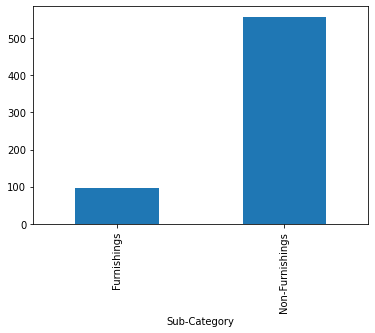

In [35]:
df.groupby('Sub-Category')['Sales'].mean().plot(kind='bar')

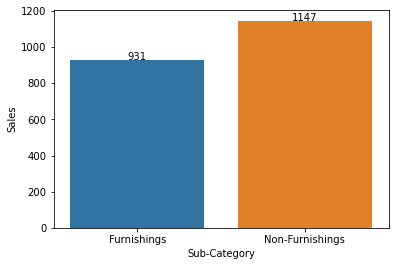

In [36]:
counts = df.groupby('Sub-Category')['Sales'].count().reset_index()

plot = sns.barplot(data=counts, x=counts['Sub-Category'], y=counts['Sales'])

for i in range(len(counts)):
    plot.annotate(counts['Sales'][i], (i, counts['Sales'][i]), horizontalalignment='center')

In [37]:
subcats = df.groupby(['Sub-Category', 'Order Date']).sum()['Sales'].reset_index()

<AxesSubplot:xlabel='Order Date', ylabel='Sales'>

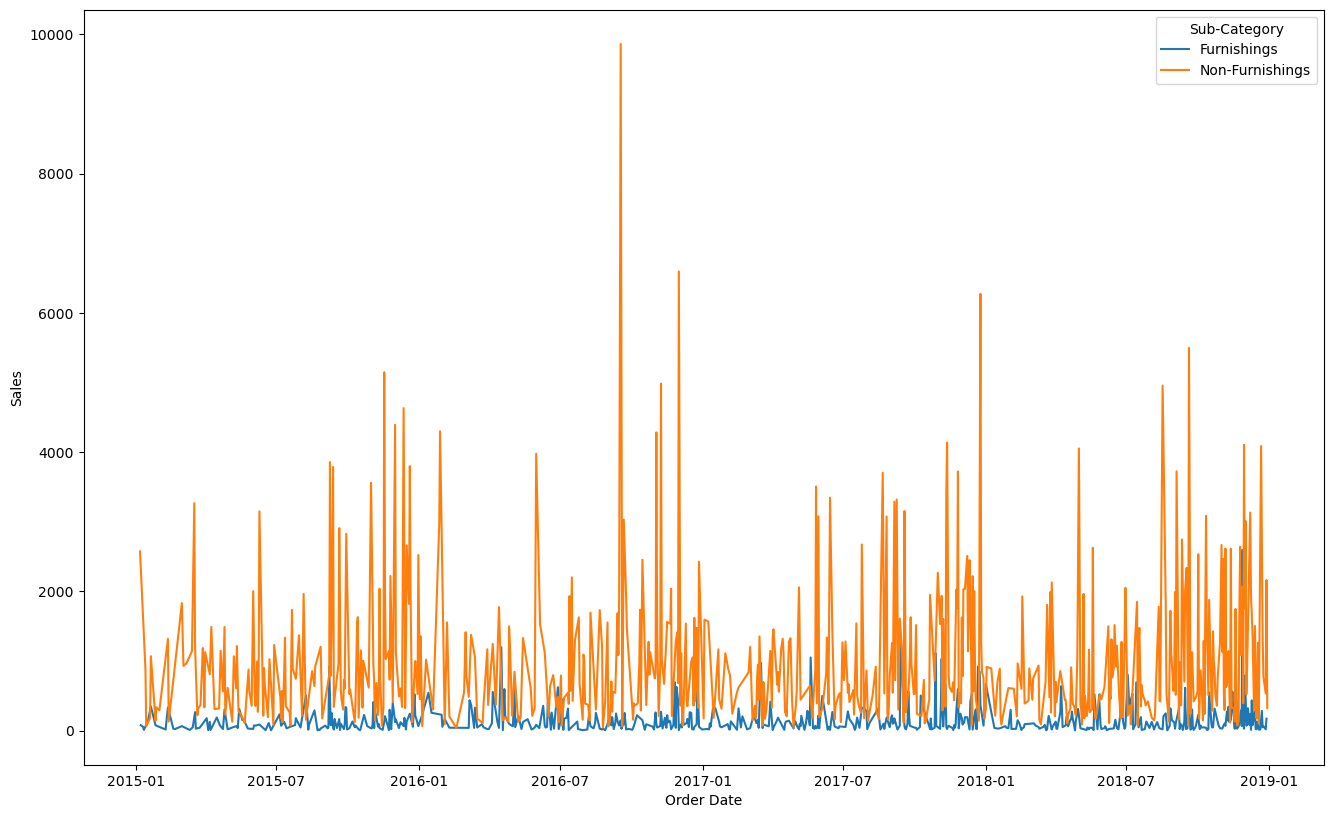

In [38]:
plt.figure(figsize=(16,10), dpi=100)
sns.lineplot(data=subcats, x='Order Date', y='Sales', hue='Sub-Category')

As we can see, on virtually every day, Furnishings is much lower than the rest non-furnishings. However, this is to be expect since there are more orders for non-furnishings which and have a mean sale of about 5x larger. I will now look at how this is split up per year.

In [39]:
def create_charts_per_year(df, feature, time_frame):
    """
    For a given feature, create a for the given time frame chart for each element of
    the given feature by year.
    """
    cols = [feature, time_frame, 'Order Year']
    temp = df.groupby(cols).sum()['Sales']
    temp = temp.reset_index()
    attrs = temp[feature].unique()
    N = len(attrs)
    
    fig, ax = plt.subplots(nrows=N, figsize=(16, 8*N))
    
    for i in range(N):
        attr = attrs[i]
        curr = temp[temp[feature]==attr]
        sns.lineplot(data=curr, x=time_frame, y='Sales', hue='Order Year', ax=ax[i], palette='Set2')
        ax[i].set_title(f'Sales per {time_frame} for {attr}')
        
    plt.show()
    

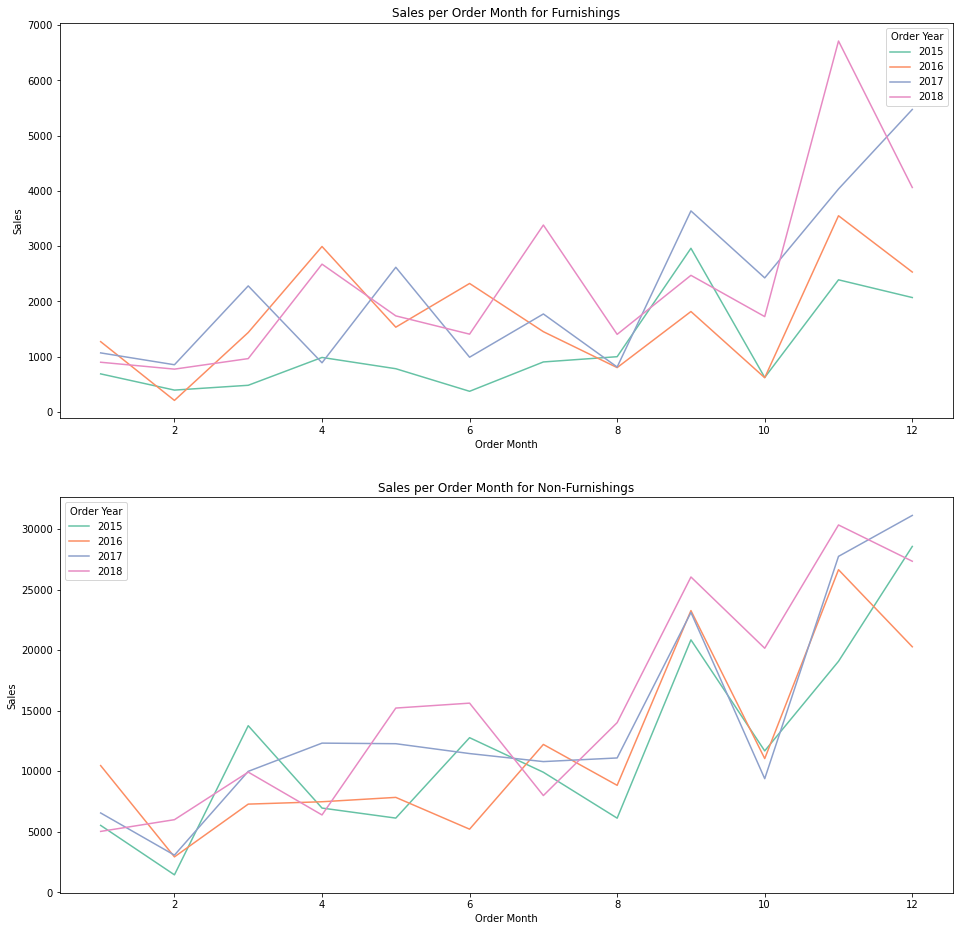

In [40]:
create_charts_per_year(df, 'Sub-Category', 'Order Month')

We can observe, from above, that there does appear to be an annual pattern. The only thing I notice is, for furnishings, in 2017, the sales increase from Nov. to Dec.

(17106.0, 17165.0)

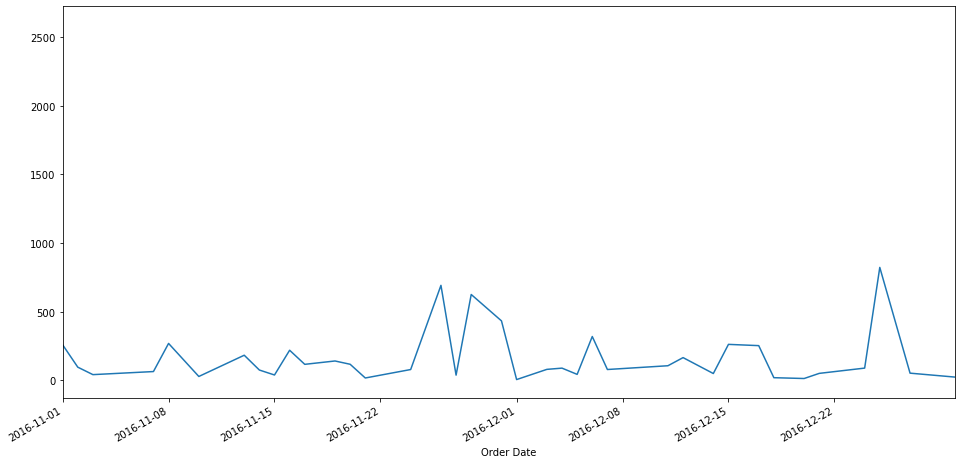

In [41]:
furnishings = df[df['Sub-Category']=='Furnishings']
furnishings.groupby(['Order Date']).sum()['Sales'].plot(figsize=(16,8))

plt.xlim(('2016-11-01', '2016-12-30'))

(17471.0, 17530.0)

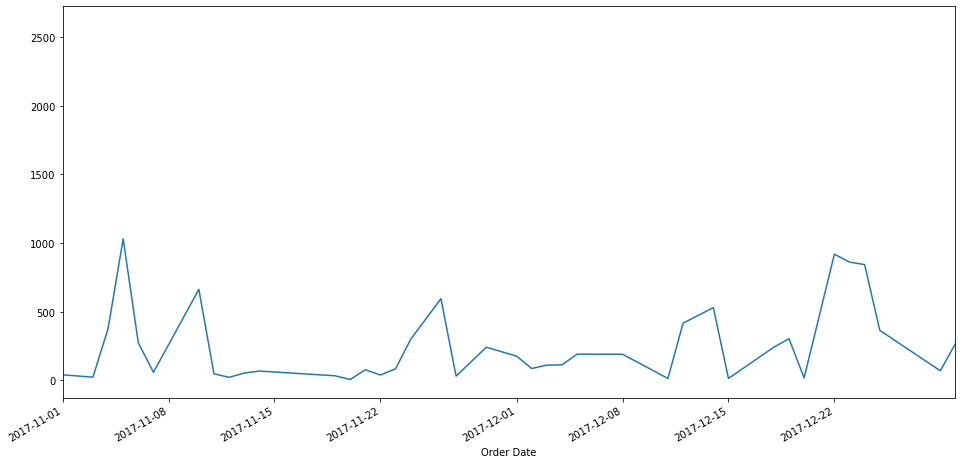

In [42]:
furnishings = df[df['Sub-Category']=='Furnishings']
furnishings.groupby(['Order Date']).sum()['Sales'].plot(figsize=(16,8))

plt.xlim(('2017-11-01', '2017-12-30'))

(17836.0, 17895.0)

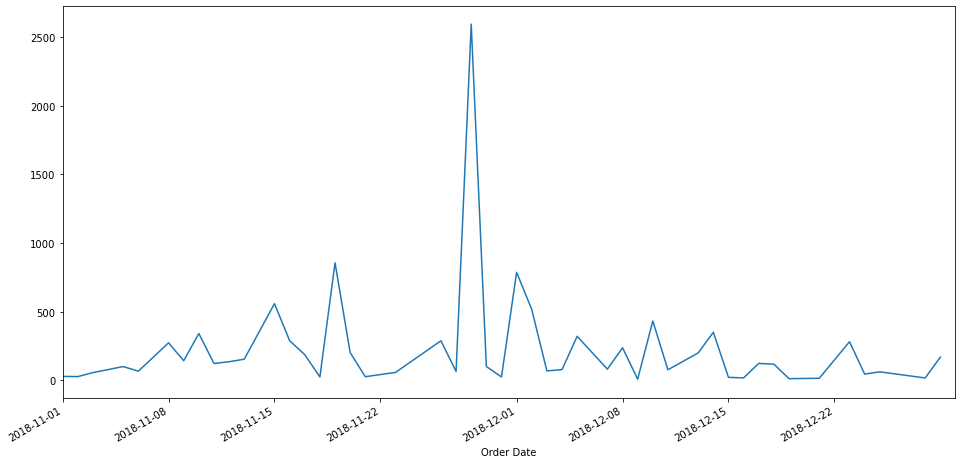

In [43]:
furnishings = df[df['Sub-Category']=='Furnishings']
furnishings.groupby(['Order Date']).sum()['Sales'].plot(figsize=(16,8))

plt.xlim(('2018-11-01', '2018-12-30'))

Comparing the three years above, I would guess that there was a Black Friday promotion to increase sales in 2018.

In [44]:
furnishings_df = df[df['Sub-Category']=='Furnishings']
non_furnishings_df = df[df['Sub-Category']!='Furnishings']

### Segment

Now that we have broken the data down into fixed sub-categories, I will look into other features, starting with segment.

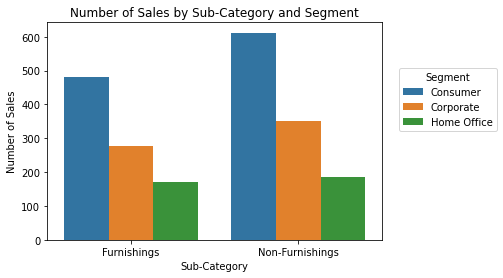

In [45]:
segment = df.groupby(['Sub-Category', 'Segment']).count()['Sales']

segment = segment.reset_index()

sns.barplot(data=segment, x='Sub-Category', y='Sales', hue='Segment')
plt.ylabel('Number of Sales')
plt.title('Number of Sales by Sub-Category and Segment')
plt.legend(loc=(1.05, 0.5), title='Segment');

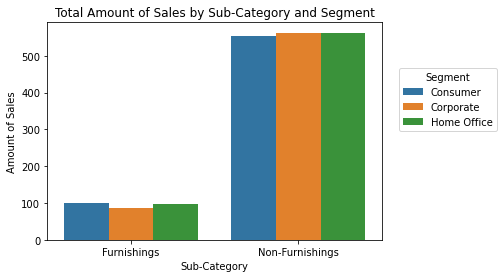

In [46]:
segment = df.groupby(['Sub-Category', 'Segment']).mean()['Sales']

segment = segment.reset_index()

sns.barplot(data=segment, x='Sub-Category', y='Sales', hue='Segment')
plt.ylabel('Amount of Sales')
plt.title('Total Amount of Sales by Sub-Category and Segment')
plt.legend(loc=(1.05, 0.5), title='Segment');

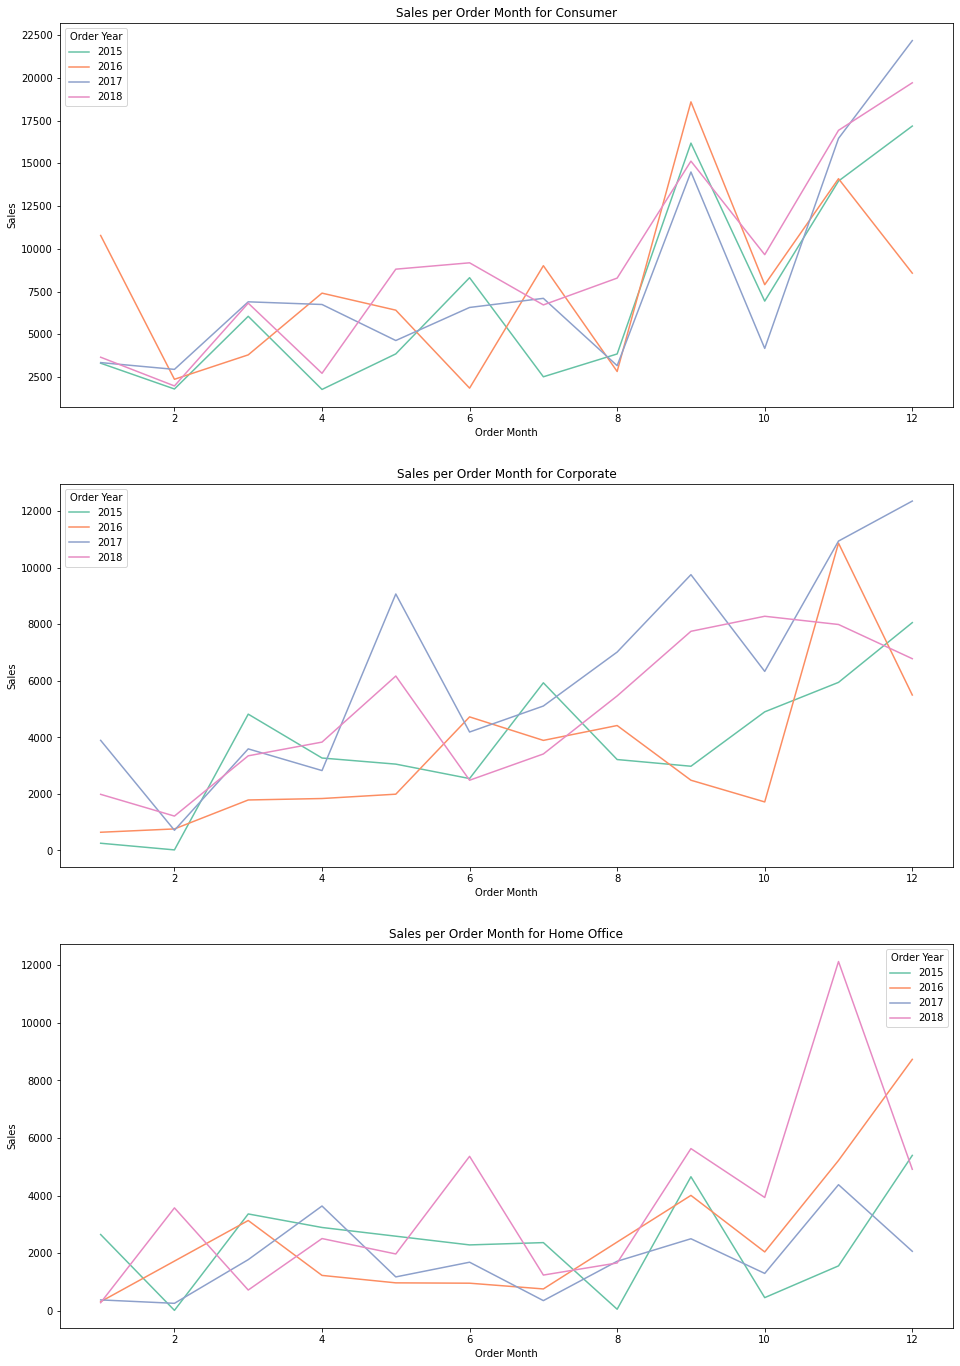

In [47]:
create_charts_per_year(df, 'Segment', 'Order Month')

The segmentation does not offer any insight here. The number of sales and total amount of sales are closely related by segment.

### Ship Mode

In [48]:
df['Ship Mode'].unique()

array(['Standard Class', 'First Class', 'Second Class', 'Same Day'],
      dtype=object)

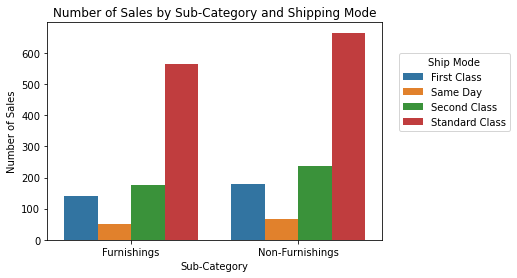

In [49]:
mode = df.groupby(['Sub-Category', 'Ship Mode']).count()['Sales']

mode = mode.reset_index()

sns.barplot(data=mode, x='Sub-Category', y='Sales', hue='Ship Mode')
plt.ylabel('Number of Sales')
plt.title('Number of Sales by Sub-Category and Shipping Mode')
plt.legend(loc=(1.05, 0.5), title='Ship Mode');

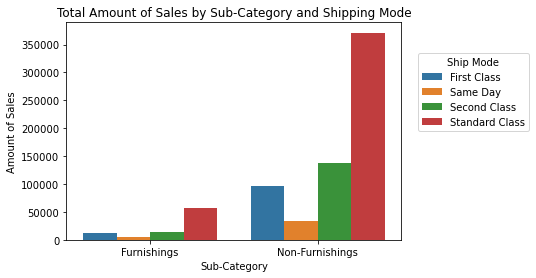

In [50]:
mode = df.groupby(['Sub-Category', 'Ship Mode']).sum()['Sales']

mode = mode.reset_index()

sns.barplot(data=mode, x='Sub-Category', y='Sales', hue='Ship Mode')
plt.ylabel('Amount of Sales')
plt.title('Total Amount of Sales by Sub-Category and Shipping Mode')
plt.legend(loc=(1.05, 0.5), title='Ship Mode');

Once again, everything looks proportional here. The shipping mode does not seem to contribute to any differences

<AxesSubplot:xlabel='Order Month', ylabel='Sales'>

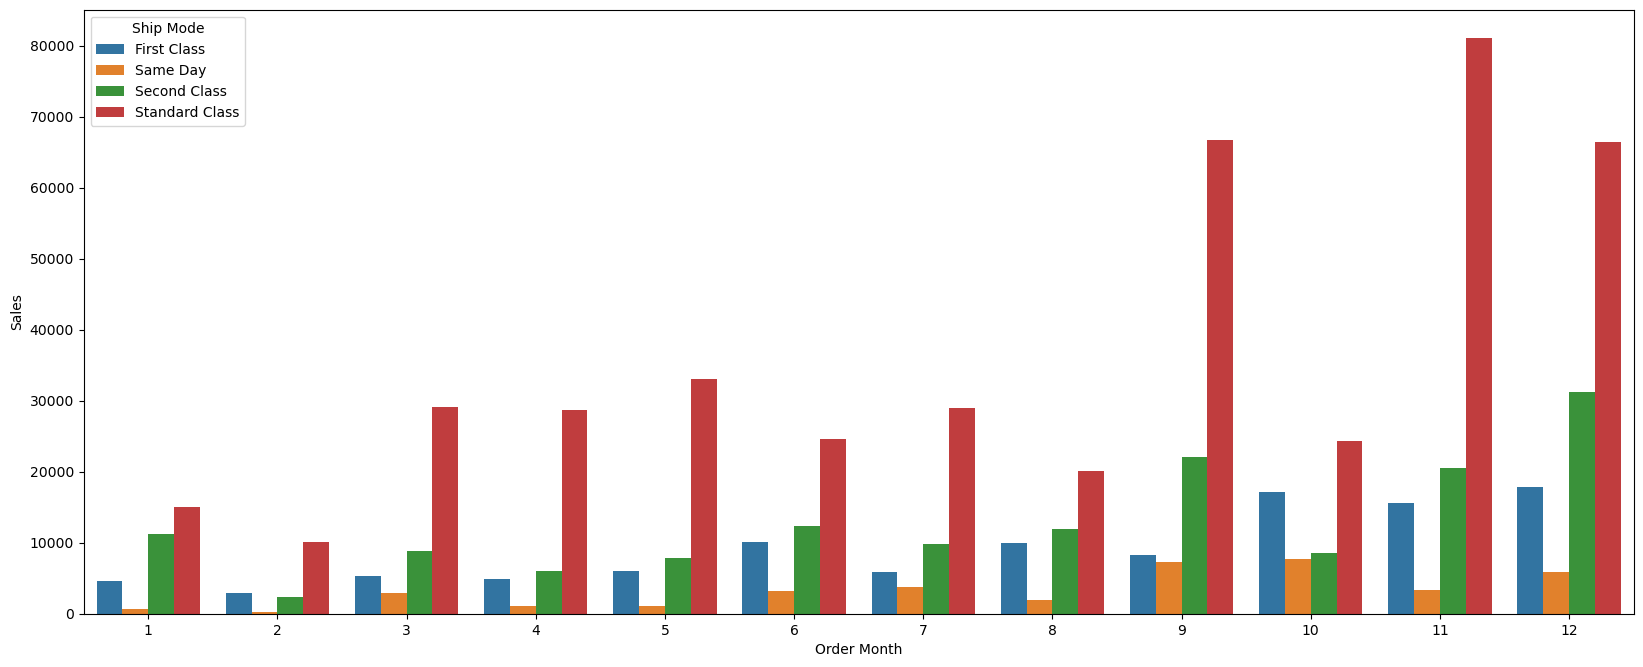

In [51]:
ship_month = df.groupby(['Ship Mode', 'Order Month']).sum()['Sales'].reset_index()

plt.figure(figsize=(20, 8), dpi=100)

sns.barplot(data=ship_month, x='Order Month', y='Sales', hue='Ship Mode')

### Region

In [52]:
df['Region'].unique()

array(['South', 'Central', 'East', 'West'], dtype=object)

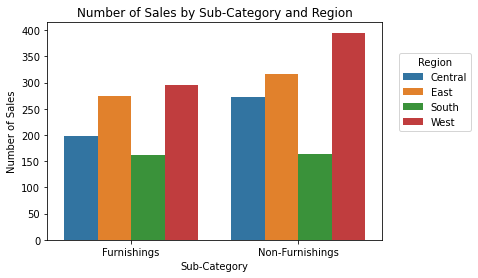

In [53]:
region = df.groupby(['Sub-Category', 'Region']).count()['Sales']

region = region.reset_index()

sns.barplot(data=region, x='Sub-Category', y='Sales', hue='Region')
plt.ylabel('Number of Sales')
plt.title('Number of Sales by Sub-Category and Region')
plt.legend(loc=(1.05, 0.5), title='Region');

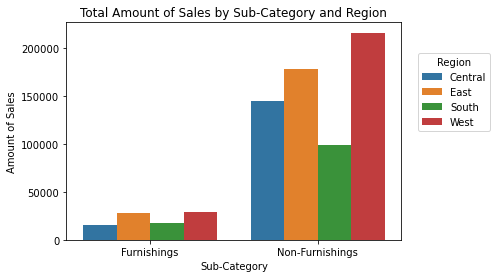

In [54]:
region = df.groupby(['Sub-Category', 'Region']).sum()['Sales']

region = region.reset_index()

sns.barplot(data=region, x='Sub-Category', y='Sales', hue='Region')
plt.ylabel('Amount of Sales')
plt.title('Total Amount of Sales by Sub-Category and Region')
plt.legend(loc=(1.05, 0.5), title='Region');

<AxesSubplot:xlabel='Order Month', ylabel='Sales'>

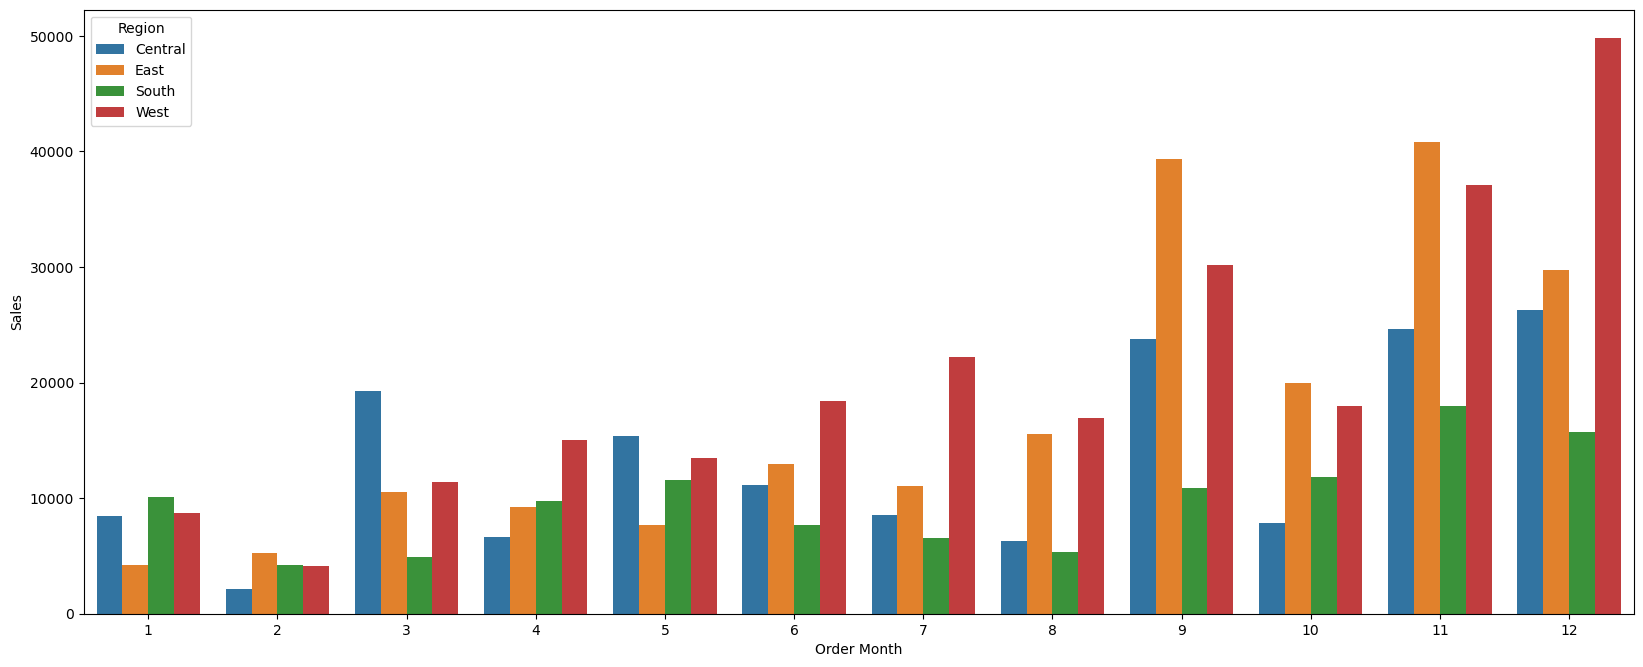

In [55]:
region_month = df.groupby(['Region', 'Order Month']).sum()['Sales'].reset_index()

plt.figure(figsize=(20, 8), dpi=100)

sns.barplot(data=region_month, x='Order Month', y='Sales', hue='Region')

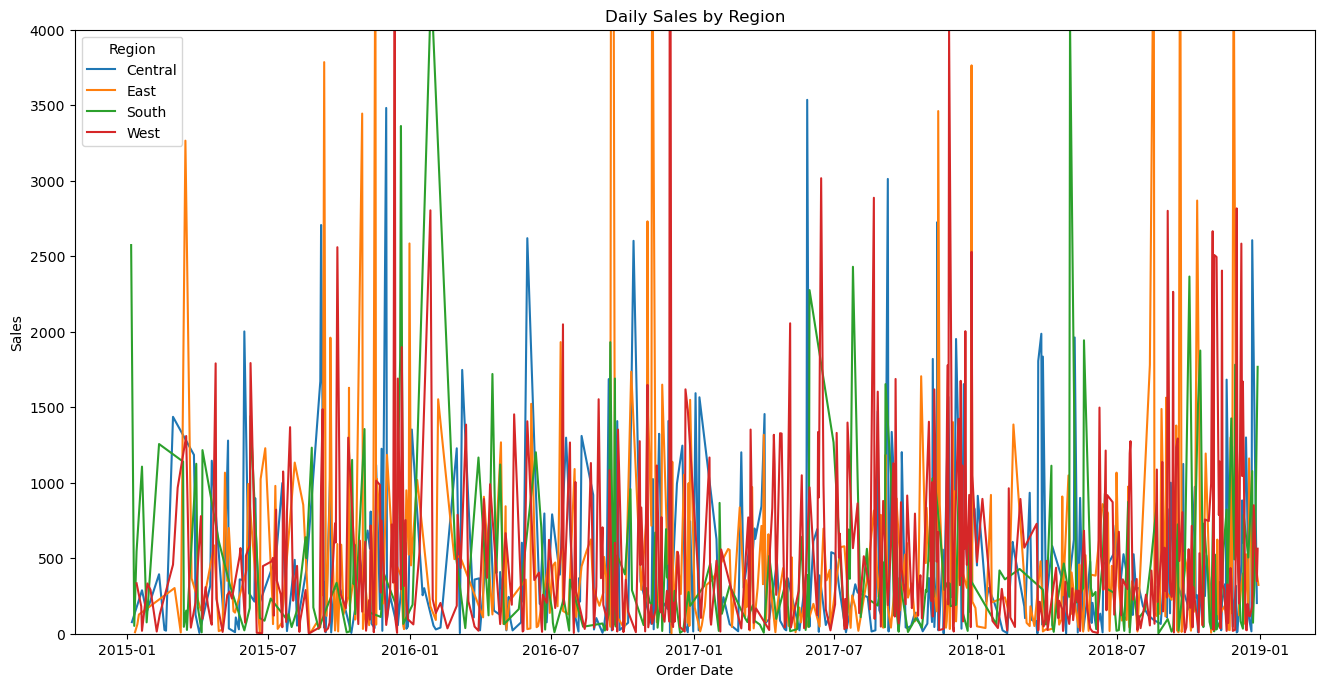

In [56]:
region_sales = df.groupby(['Region', 'Order Date']).sum()['Sales'].reset_index()

plt.figure(figsize=(16, 8), dpi=100)
sns.lineplot(data=region_sales, x='Order Date', y='Sales', hue='Region')
plt.ylim(0,4000)
plt.title('Daily Sales by Region');

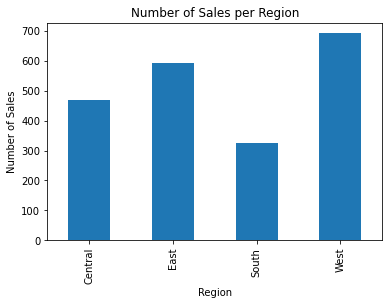

In [57]:
df.groupby(['Region']).count()['Sales'].plot(kind='bar')
plt.ylabel('Number of Sales')
plt.title('Number of Sales per Region');

Looking at the breakdown by Region does not appear to offer any insights. There is quite a disparity regarding sales by region, monthly and daily. However, breaking it down into each region seems rather futile as there are not many orders for forecasting (keep in mind this is four years of data, so ~1400 days).

### States

In [58]:
states_total = df.groupby(['State']).sum()['Sales'].reset_index().sort_values(by='Sales', ascending=False)

codes = {'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA','Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','District of Columbia':'DC','Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL','Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA','Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN','Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV','New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY','North Carolina': 'NC','North Dakota': 'ND','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR','Pennsylvania': 'PA','Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN','Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virginia': 'VA','Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY'}

states_total['State Abbr'] = states_total['State'].apply(lambda x: codes[x])

In [59]:


data = dict(type='choropleth',
            locations=states_total['State Abbr'],
            locationmode='USA-states',
            text=states_total['State'],
            colorscale='Portland',
            z=states_total['Sales'])
layout = dict(geo={'scope':'usa'}, title=f'Sales per State')
choromap = go.Figure(data=[data], layout=layout)

iplot(choromap)

Overall, we can see that a good chunk of the total sales come from California and Texax. Specifically.

In [60]:
total_sales = states_total['Sales'].sum()

top_two_sales = states_total['Sales'][:2].sum()

perc = top_two_sales/total_sales*100

print(f"{np.round(perc,2)}% of the total Furniture sales comes from New York or California")

33.59% of the total Furniture sales comes from New York or California


In [61]:
top_four_sales = states_total['Sales'][:4].sum()

perc = top_four_sales/total_sales*100

print(f"{np.round(perc,2)}% of the total Furniture sales comes from New York, California, Texas, or Washington")

47.89% of the total Furniture sales comes from New York, California, Texas, or Washington


This shows that the top 4 states contribute to about half the overall sales, but similarly to above, breaking down the data further is not a good idea as the sample sizes become too small.

# Forecasting

I will now forecast using the Facebook Prophet model. I will split the furniture data set into the two described above: Furnishings and Non-Furnishings and predict on each.

In [62]:
furnishings_data = furnishings_df.groupby(['Order Date']).sum()['Sales'].reset_index()
furnishings_data = furnishings_data.rename({'Order Date': 'ds', 'Sales': 'y'}, axis=1)

non_furnishings_data = non_furnishings_df.groupby(['Order Date']).sum()['Sales'].reset_index()
non_furnishings_data = non_furnishings_data.rename({'Order Date': 'ds', 'Sales': 'y'}, axis=1)

In [63]:
furnishings_data['3 Day Sales Avg'] = furnishings_data['y'].rolling(3).mean()
non_furnishings_data['3 Day Sales Avg'] = non_furnishings_data['y'].rolling(3).mean()

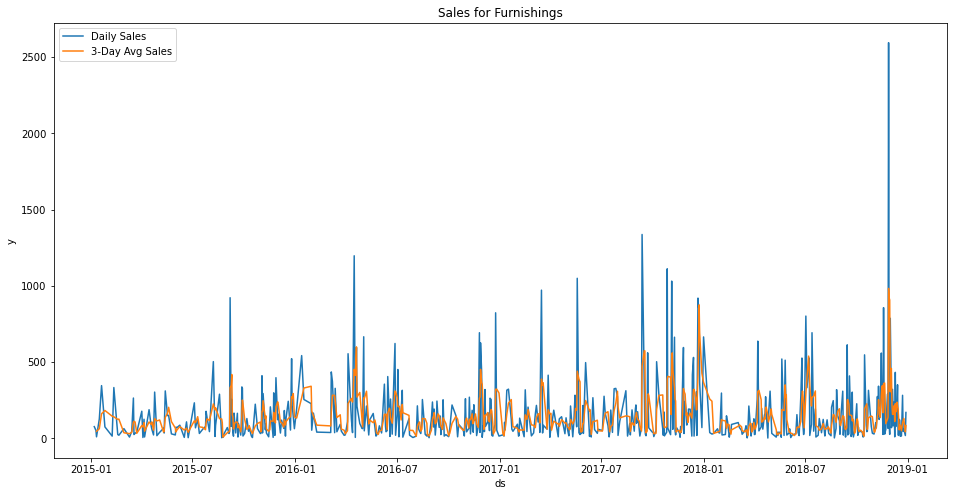

In [64]:
plt.figure(figsize=(16, 8))
sns.lineplot(data=furnishings_data, x='ds', y='y', label='Daily Sales')
sns.lineplot(data=furnishings_data, x='ds', y='3 Day Sales Avg', label='3-Day Avg Sales')

plt.legend(loc=('upper left'))
plt.title('Sales for Furnishings');

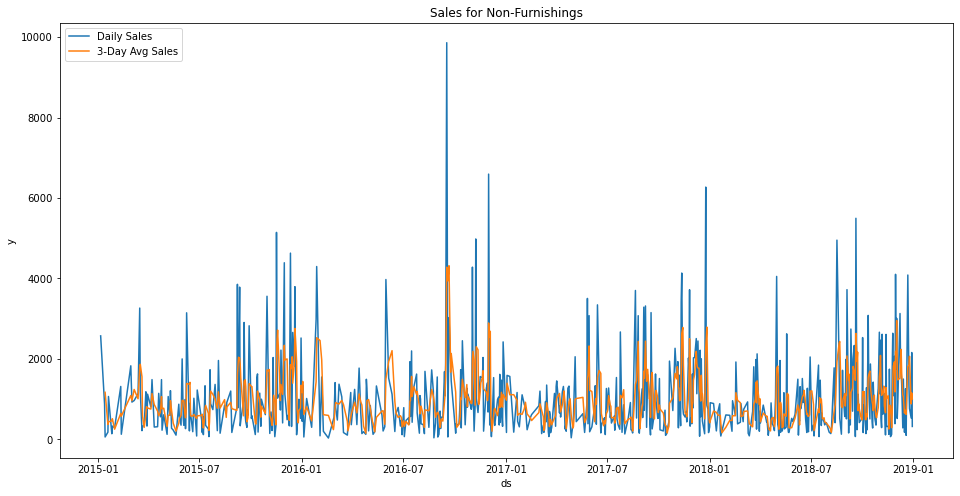

In [65]:
plt.figure(figsize=(16, 8))
sns.lineplot(data=non_furnishings_data, x='ds', y='y', label='Daily Sales')
sns.lineplot(data=non_furnishings_data, x='ds', y='3 Day Sales Avg', label='3-Day Avg Sales')

plt.legend(loc=('upper left'))
plt.title('Sales for Non-Furnishings');

As we can see, the 3-day avg sales smooths the curves out a little bit while still taking notice of the outliers/extreme values. I chose 3-day average over a larger number because of the daily sales average seen above. Since Tuesday and Saturday have more sales than the rest, I did not want to make the rolling average time too long to miss the spikes around these days.

In [66]:
furnishings_model_data = furnishings_data[['ds', '3 Day Sales Avg']].rename({'3 Day Sales Avg': 'y'}, axis=1)
non_furnishings_model_data = non_furnishings_data[['ds', '3 Day Sales Avg']].rename({'3 Day Sales Avg': 'y'}, axis=1)

In [67]:
m_furn = prophet.Prophet()
m_furn.fit(furnishings_model_data)


future_furn = m_furn.make_future_dataframe(periods=365)

forecast_furn = m_furn.predict(future_furn)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [68]:
results = forecast_furn[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
results = results.merge(furnishings_model_data, on='ds', how='left')

results_no_nulls = results.dropna(axis=0)

In [69]:
mean_absolute_percentage_error(results_no_nulls['y'], results_no_nulls['yhat'])

0.8973511339386568

In [70]:
results_no_nulls['y'].describe()

count    586.000000
mean     151.918754
std      126.259021
min        7.928000
25%       67.839333
50%      120.287667
75%      188.467833
max      982.886667
Name: y, dtype: float64

The mean absolute percentage error (MAPE) is showing us on that, on average, each estimated yhat is roughly 89% off of the actual value. However, keeping in mind that the mean ~ 152 and std ~ 126 (along with potential limitless outliers), this does not seem like a bad result.

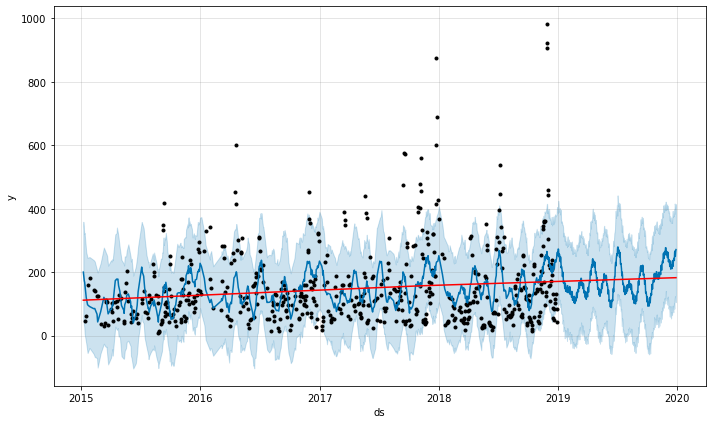

In [71]:
fig_furn = m_furn.plot(forecast_furn)
a_furn = add_changepoints_to_plot(fig_furn.gca(), m_furn, forecast_furn)

In [72]:
m_non = prophet.Prophet()
m_non.fit(non_furnishings_model_data)

future_non = m_non.make_future_dataframe(periods=365)

forecast_non = m_non.predict(future_non)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [73]:
results_non = forecast_non[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
results_non = results_non.merge(non_furnishings_model_data, on='ds', how='left')

results_non_no_nulls = results_non.dropna(axis=0)

mean_absolute_percentage_error(results_non_no_nulls['y'], results_non_no_nulls['yhat'])

0.5418094929859694

In [74]:
results_non_no_nulls['y'].describe()

count     640.000000
mean      994.533690
std       601.500338
min       155.564667
25%       577.205458
50%       855.735400
75%      1219.102325
max      4316.944667
Name: y, dtype: float64

For the non-furnishing data, our MAPE is even lower (around 54% off). For the same issues above, we should not expect a very good estimate overall.

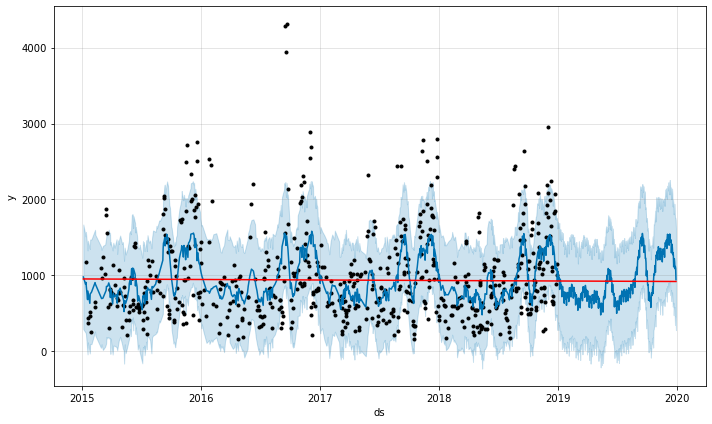

In [75]:
fig_non = m_non.plot(forecast_non)
a_non = add_changepoints_to_plot(fig_non.gca(), m_non, forecast_non)